In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
#from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score
import pickle

In [59]:
df=pd.read_csv('../data/raw/XGBoost_train.csv')

df=df.drop("id" , axis=1)
type_mapping = {'L': 0, 'M': 1, 'H': 2}

df['Type_numeric'] = df['Type'].map(type_mapping)

df['Numeric_ID'] = df['Product ID'].str.extract('(\d+)')
df['Numeric_ID'] = pd.to_numeric(df['Numeric_ID'])

df=df.drop("Product ID" , axis=1)
df=df.drop("Type" , axis=1)

In [60]:
import pdpipe as pdp

target=df.loc[:,'Machine failure']
features=df.drop('Machine failure' , axis=1)

features_train, features_test, target_train, target_test= train_test_split(features , target,                                                          
                                                                            random_state = 42,
                                                                            test_size = 0.2 )

# Calculate normalized cross-tabulation
var = pd.crosstab(index=features_train["Numeric_ID"], columns='ratio', 
                  normalize='columns').sort_values(by='ratio', ascending=False)

# Print top 10 categories
print(var.index[:10])

# Replace categories beyond top 10 with 'other'
features_train.loc[~features_train["Numeric_ID"].isin(var.index[:10]), "Numeric_ID"] = 'other'
print(features_train["Numeric_ID"].unique())
# for test 

# Replace categories beyond top 10 with 'other'
features_test.loc[~features_test["Numeric_ID"].isin(var.index[:10]), "Numeric_ID"] = 'other'
print(features_test["Numeric_ID"].unique())

### Applying onehote encode to categorical features
features_train.loc[:,"Numeric_ID"]=features_train.loc[:,"Numeric_ID"].astype(str)
features_test.loc[:,"Numeric_ID"]=features_test.loc[:,"Numeric_ID"].astype(str)

onehot = pdp.OneHotEncode(['Numeric_ID'], drop_first=False)
features_train = onehot.fit_transform(features_train)
features_test = onehot.transform(features_test)

print(features_train.shape)
print(features_test.shape)



Index([53257, 49056, 54275, 53271, 53258, 48892, 53140, 48897, 48894, 53270], dtype='int64', name='Numeric_ID')
['other' 48892 49056 53140 53257 54275 53271 48894 53270 53258 48897]
[53271 'other' 53258 48894 48892 54275 53257 53270 48897 49056 53140]
(109143, 22)
(27286, 22)


In [22]:
features_train_copy=features_train.copy()
col_correlated= ['Air temperature [K]', 'Process temperature [K]']
pca=PCA(n_components=0.90)
pipe_std_pca=Pipeline([('std' , StandardScaler()),('pca' , pca)])
pipe_std_pca.fit(features_train_copy.loc[:,col_correlated])
print('\033[1mas we know these features are highly correlated and we can apply dimensionality reduction\033[0m')
print('\033[1mas from this method for 0.95 of variance we get 2 components\033[0m')
print('n_components:',pca.n_components_)

as we know these features are highly correlated and we can apply dimensionality reduction
as from this method for 0.95 of variance we get 2 components
n_components: 1


In [61]:
### Applying pca
col_correlated= ['Air temperature [K]', 'Process temperature [K]']
drop_col=[]

keep_col = [col for col in features_train.columns if col not in col_correlated and col not in drop_col]

pipe_std_pca=Pipeline([('std' , StandardScaler()),('pca' , PCA(n_components=0.9))])

col_dropper=ColumnTransformer([('pass_throu' , 'passthrough' , keep_col)] , remainder='drop')
corr_transformer=ColumnTransformer([('pipe_std_pca' , pipe_std_pca ,col_correlated )] , remainder=col_dropper)
col_names=['pca_0']+keep_col
features_train = pd.DataFrame(corr_transformer.fit_transform(features_train) , columns=col_names)
features_test = pd.DataFrame(corr_transformer.transform(features_test) , columns=col_names)
print(features_train.shape)
print(features_test.shape)

(109143, 21)
(27286, 21)


gridsearch_results_RandomForestClassifier:
rf_best_estimator_: RandomForestClassifier(class_weight='balanced', max_depth=26, n_estimators=50,
                       random_state=42)
rf_best_score_: 0.8560165751669448


F1_rf:  0.8626444159178434
Precision_rf:  0.9853372434017595
Recall_rf:  0.7671232876712328


<Axes: >

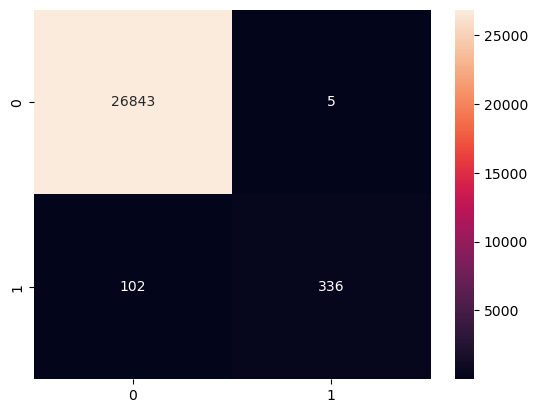

In [27]:
model_rf=RandomForestClassifier(n_estimators=50 , class_weight='balanced' , random_state=42)
search_space_rf = {'max_depth': np.geomspace(start=3, stop=50, num=10, dtype='int'),
'min_samples_leaf': np.geomspace(start=1, stop=500, num=10, dtype='int')}

model_rf_optimized=GridSearchCV(estimator=model_rf , param_grid=search_space_rf , cv=5 , scoring='f1' , n_jobs=-1)

model_rf_optimized.fit(features_train , target_train)

target_test_pred_optimized_rf=model_rf_optimized.predict(features_test)

print('gridsearch_results_RandomForestClassifier:')
print('rf_best_estimator_:',model_rf_optimized.best_estimator_)
print('rf_best_score_:',model_rf_optimized.best_score_)
print('\n')
print('F1_rf: ', f1_score(target_test, target_test_pred_optimized_rf))
print('Precision_rf: ', precision_score(target_test, target_test_pred_optimized_rf))
print('Recall_rf: ', recall_score(target_test, target_test_pred_optimized_rf))
confusion_matrix_rf_optimized= confusion_matrix(target_test, target_test_pred_optimized_rf)
sns.heatmap(confusion_matrix_rf_optimized, annot=True, fmt='d')

In [30]:
####2
#f1_orig=f1_score(target_test, target_test_pred_optimized_rf)
#dict_importance=[]
#for col in features_test.columns:
#    features_test_perm=features_test.copy()
#    age_series_perm=features_test_perm.loc[:,col].sample(frac=1 , replace=False ,random_state=42 )
#    age_series_perm = age_series_perm.reset_index(drop=True)
#    features_test_perm.loc[:, col] = age_series_perm
#    target_test_pred_perm = model_rf_optimized.predict(features_test_perm)
#    f1_age = f1_score(target_test, target_test_pred_perm)
#    div=f1_orig - f1_age
#    dict_importance.append(div)
#perm_importances = pd.DataFrame(dict_importance , index=features_test.columns , columns=['Importance'])
#perm_importances=perm_importances.sort_values(by='Importance' , ascending=True)
#fig , ax =plt.subplots(figsize=(7,40))
#perm_importances.plot(kind='barh', ax=ax)

In [31]:
features_train['speed_power'] = features_train['Rotational speed [rpm]'] * (2 * np.pi / 60) / (features_train['Rotational speed [rpm]'] * (2 * np.pi / 60) * features_train['Torque [Nm]'])
features_test['speed_power'] = features_test['Rotational speed [rpm]'] * (2 * np.pi / 60) / (features_test['Rotational speed [rpm]'] * (2 * np.pi / 60) * features_test['Torque [Nm]'])

features_train['torque_power'] = features_train['Torque [Nm]'] / (features_train['Rotational speed [rpm]'] * (2 * np.pi / 60) * features_train['Torque [Nm]'])
features_test['torque_power'] = features_test['Torque [Nm]'] / (features_test['Rotational speed [rpm]'] * (2 * np.pi / 60) * features_test['Torque [Nm]'])


gridsearch_results_RandomForestClassifier:
rf_best_estimator_: RandomForestClassifier(class_weight='balanced', max_depth=26, n_estimators=50,
                       random_state=42)
rf_best_score_: 0.8507272208002981


F1_rf:  0.8527131782945736
Precision_rf:  0.9821428571428571
Recall_rf:  0.7534246575342466


<Axes: >

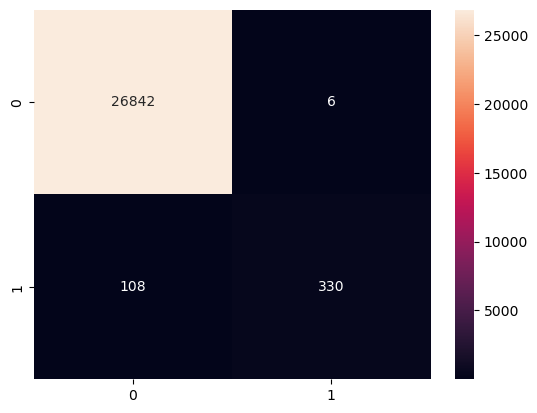

In [33]:
model_rf=RandomForestClassifier(n_estimators=50 , class_weight='balanced' , random_state=42)
search_space_rf = {'max_depth': np.geomspace(start=3, stop=50, num=10, dtype='int'),
'min_samples_leaf': np.geomspace(start=1, stop=500, num=10, dtype='int')}

model_rf_optimized_2=GridSearchCV(estimator=model_rf , param_grid=search_space_rf , cv=5 , scoring='f1' , n_jobs=-1)

model_rf_optimized_2.fit(features_train , target_train)

target_test_pred_optimized_rf=model_rf_optimized_2.predict(features_test)

print('gridsearch_results_RandomForestClassifier:')
print('rf_best_estimator_:',model_rf_optimized_2.best_estimator_)
print('rf_best_score_:',model_rf_optimized_2.best_score_)
print('\n')
print('F1_rf: ', f1_score(target_test, target_test_pred_optimized_rf))
print('Precision_rf: ', precision_score(target_test, target_test_pred_optimized_rf))
print('Recall_rf: ', recall_score(target_test, target_test_pred_optimized_rf))
confusion_matrix_rf_optimized= confusion_matrix(target_test, target_test_pred_optimized_rf)
sns.heatmap(confusion_matrix_rf_optimized, annot=True, fmt='d')

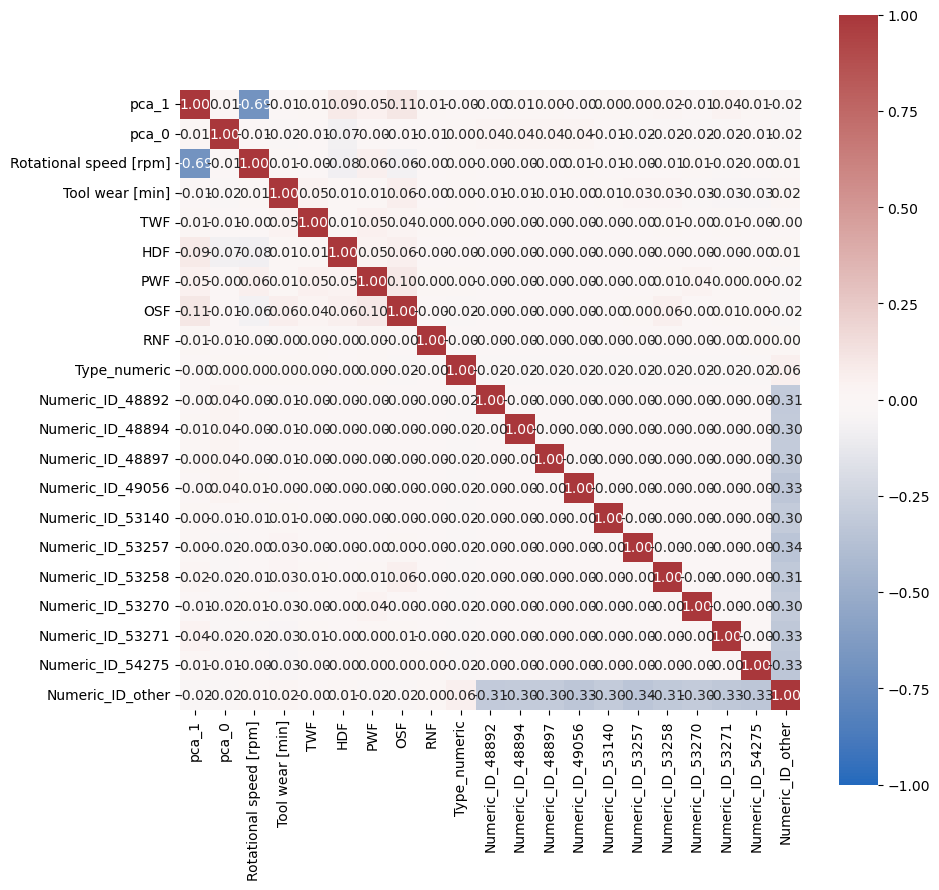

In [66]:
# Select relevant features for correlation analysis
# Create a correlation matrix and plot a heatmap
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(features_train.corr(), annot=True, square=True, vmin=-1, fmt='.2f', cmap="vlag", ax=ax);


In [62]:
features_train['power'] =features_train['Rotational speed [rpm]'] * (2 * np.pi / 60) * features_train['Torque [Nm]']
features_test['power'] =features_test['Rotational speed [rpm]'] * (2 * np.pi / 60) * features_test['Torque [Nm]']


gridsearch_results_RandomForestClassifier:
rf_best_estimator_: RandomForestClassifier(class_weight='balanced', max_depth=26, n_estimators=50,
                       random_state=42)
rf_best_score_: 0.8549224948102149


F1_rf:  0.8615384615384616
Precision_rf:  0.9824561403508771
Recall_rf:  0.7671232876712328


<Axes: >

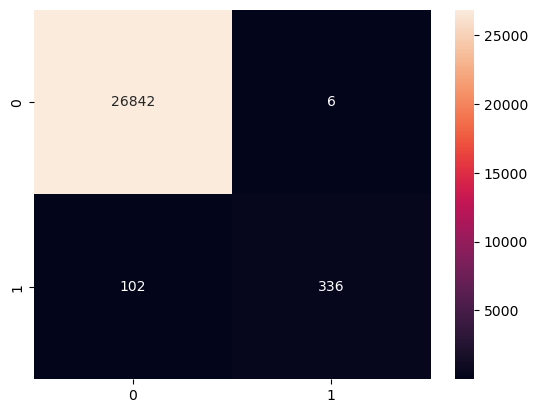

In [48]:
model_rf=RandomForestClassifier(n_estimators=50 , class_weight='balanced' , random_state=42)
search_space_rf = {'max_depth': np.geomspace(start=3, stop=50, num=10, dtype='int'),
'min_samples_leaf': np.geomspace(start=1, stop=500, num=10, dtype='int')}

model_rf_optimized_3=GridSearchCV(estimator=model_rf , param_grid=search_space_rf , cv=5 , scoring='f1' , n_jobs=-1)

model_rf_optimized_3.fit(features_train , target_train)

target_test_pred_optimized_rf=model_rf_optimized_3.predict(features_test)

print('gridsearch_results_RandomForestClassifier:')
print('rf_best_estimator_:',model_rf_optimized_3.best_estimator_)
print('rf_best_score_:',model_rf_optimized_3.best_score_)
print('\n')
print('F1_rf: ', f1_score(target_test, target_test_pred_optimized_rf))
print('Precision_rf: ', precision_score(target_test, target_test_pred_optimized_rf))
print('Recall_rf: ', recall_score(target_test, target_test_pred_optimized_rf))
confusion_matrix_rf_optimized= confusion_matrix(target_test, target_test_pred_optimized_rf)
sns.heatmap(confusion_matrix_rf_optimized, annot=True, fmt='d')

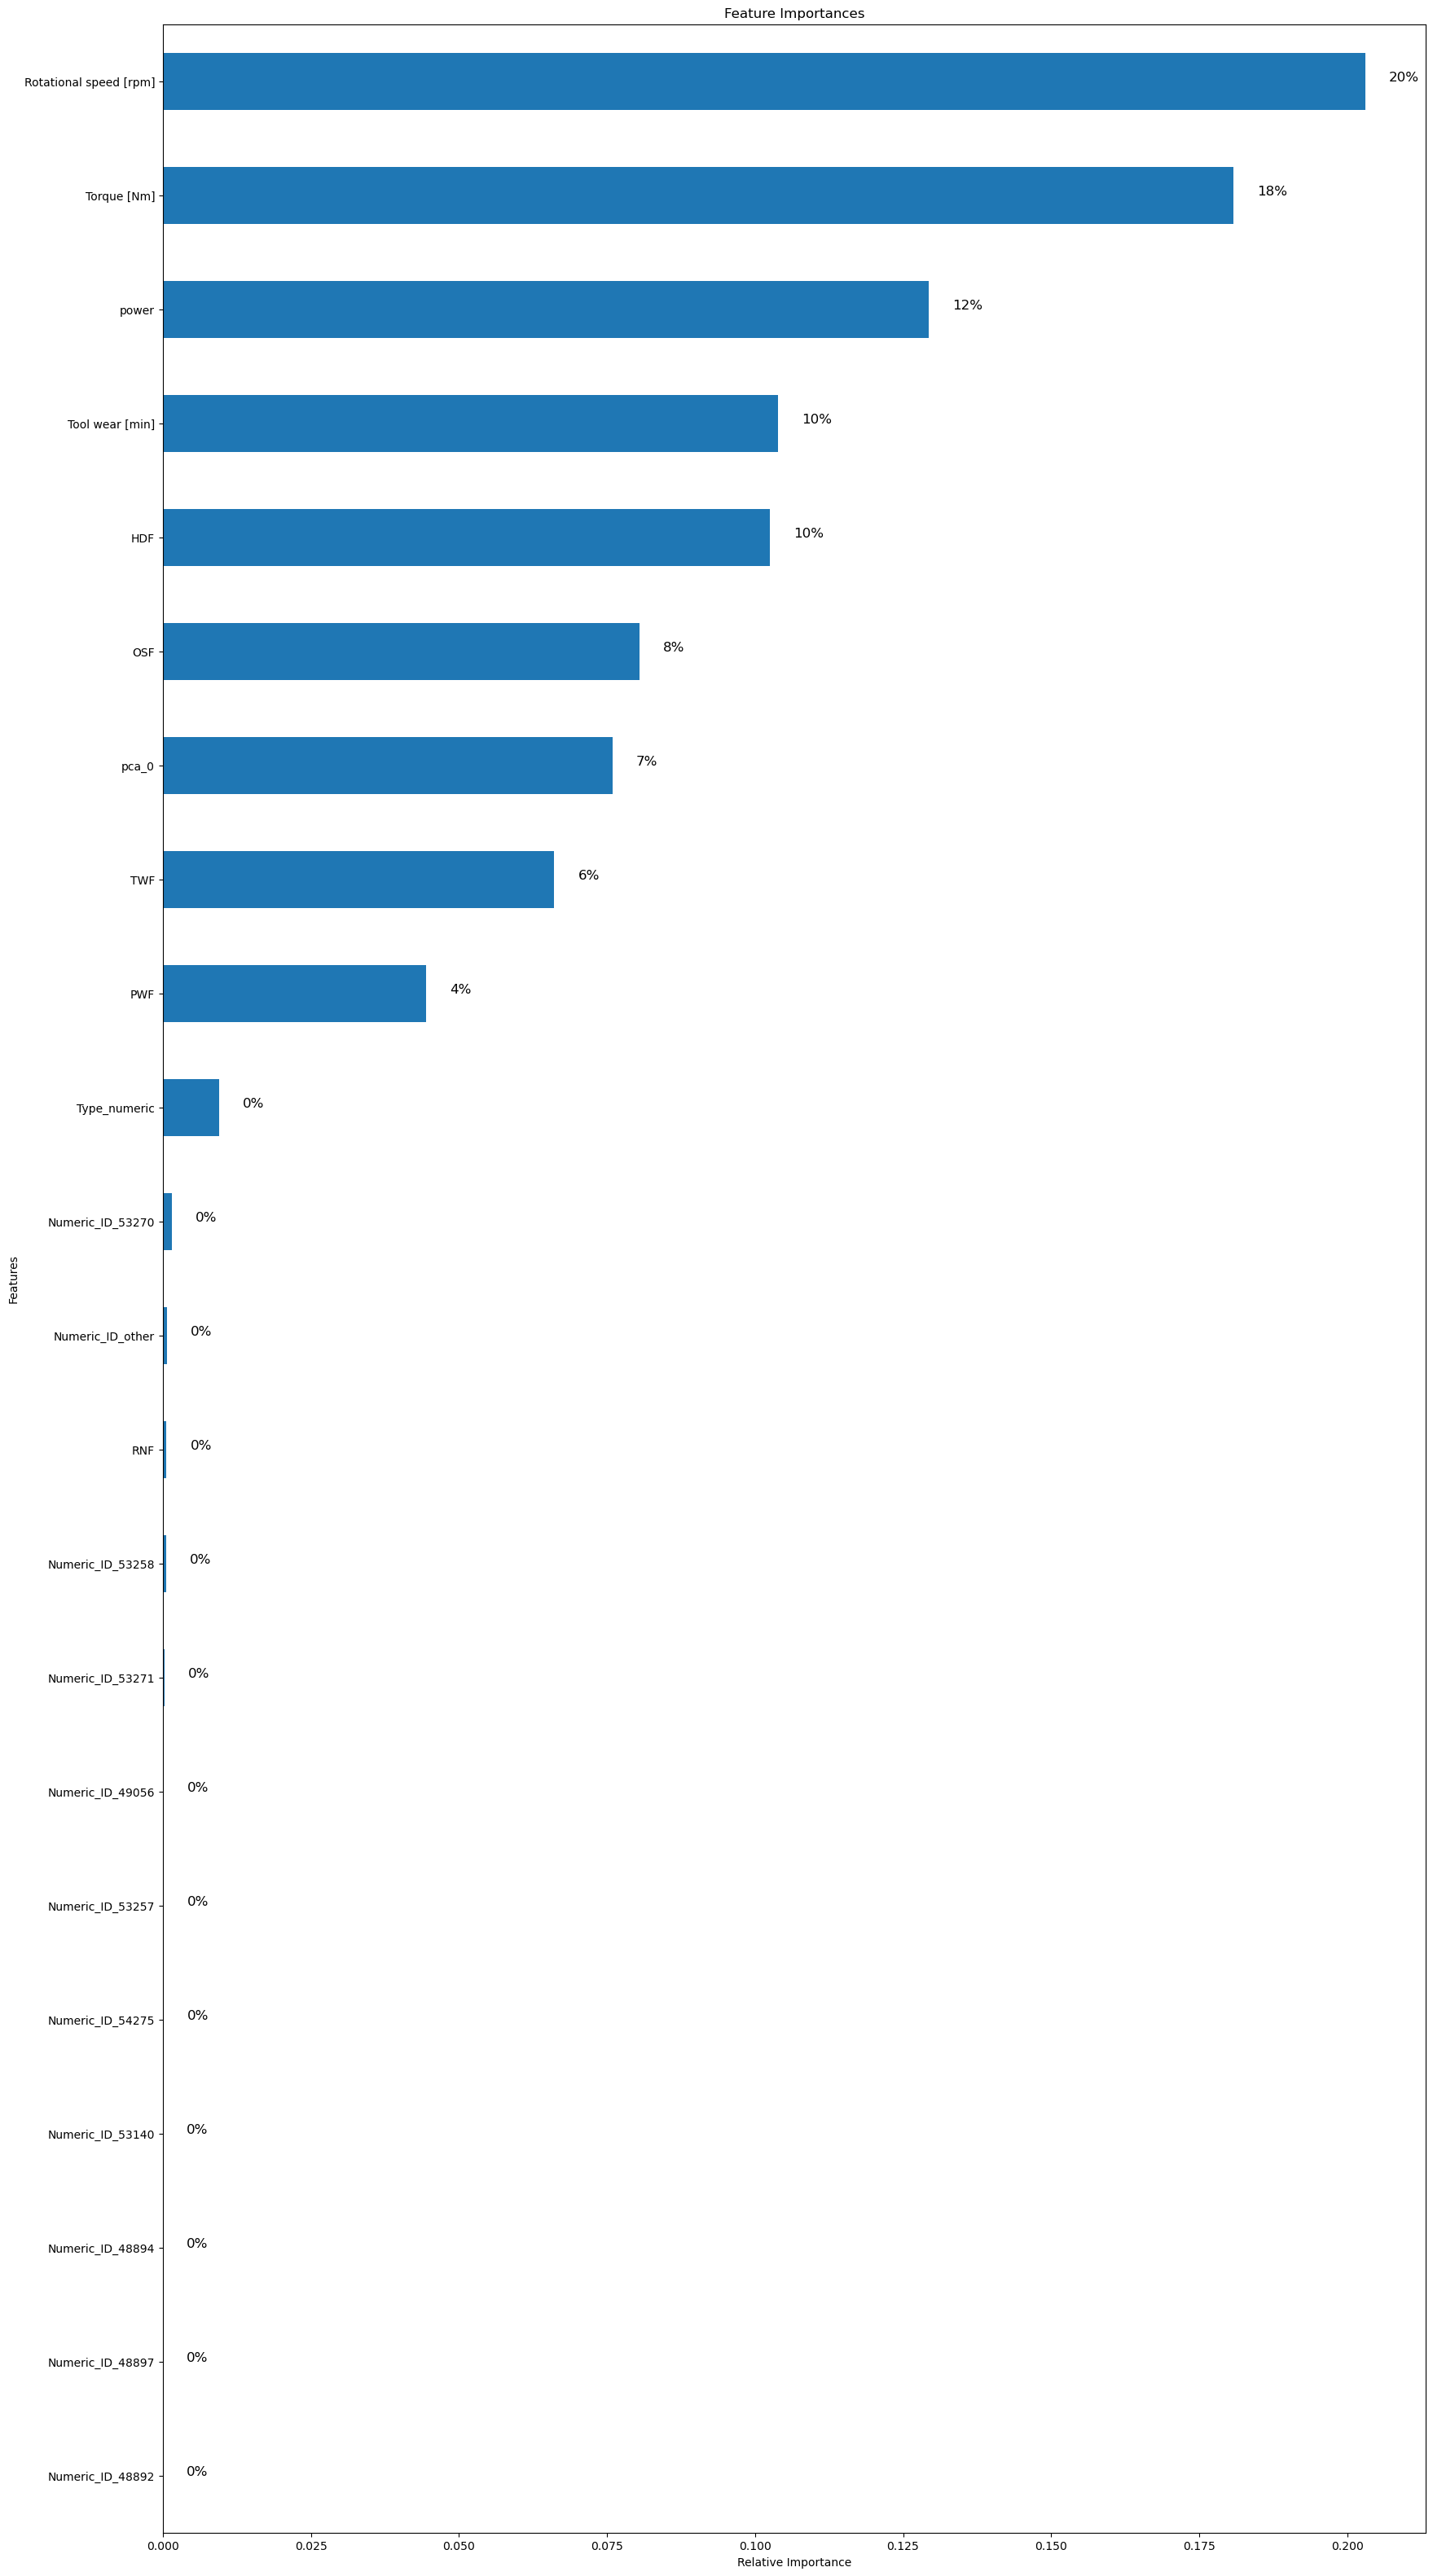

In [56]:
fig, ax = plt.subplots(figsize=(20, 40))

# Compute feature importances and sort them
feature_importance = pd.Series((model_rf_optimized_3.best_estimator_).feature_importances_,
                               index=features_train.columns).sort_values()

# Plotting horizontal bar chart for feature importances
feature_importance.plot(kind='barh', ax=ax, title='Feature Importances')
ax.set_xlabel('Relative Importance')
ax.set_ylabel('Features')

# Adding text annotations for importance percentages
for idx in range(len(feature_importance.index)):
    ax.text(s='{}%'.format(int(100 * feature_importance.iloc[idx])),
            x=feature_importance.iloc[idx] + 0.004,
            y=idx,
            size=12,
            color='black')


In [54]:
features_train_copy=features_train.copy()
col_correlated= ['power', 'Torque [Nm]']
pca=PCA(n_components=0.97)
pipe_std_pca=Pipeline([('std' , StandardScaler()),('pca' , pca)])
pipe_std_pca.fit(features_train_copy.loc[:,col_correlated])
print('\033[1mas we know these features are highly correlated and we can apply dimensionality reduction\033[0m')
print('\033[1mas from this method for 0.95 of variance we get 2 components\033[0m')
print('n_components:',pca.n_components_)

as we know these features are highly correlated and we can apply dimensionality reduction
as from this method for 0.95 of variance we get 2 components
n_components: 1


In [63]:
### Applying pca
col_correlated= ['power', 'Torque [Nm]']
drop_col=[]

keep_col = [col for col in features_train.columns if col not in col_correlated and col not in drop_col]

pipe_std_pca=Pipeline([('std' , StandardScaler()),('pca' , PCA(n_components=0.9))])

col_dropper=ColumnTransformer([('pass_throu' , 'passthrough' , keep_col)] , remainder='drop')
corr_transformer=ColumnTransformer([('pipe_std_pca' , pipe_std_pca ,col_correlated )] , remainder=col_dropper)
col_names=['pca_1']+keep_col
features_train = pd.DataFrame(corr_transformer.fit_transform(features_train) , columns=col_names)
features_test = pd.DataFrame(corr_transformer.transform(features_test) , columns=col_names)
print(features_train.shape)
print(features_test.shape)

(109143, 21)
(27286, 21)


gridsearch_results_RandomForestClassifier:
rf_best_estimator_: RandomForestClassifier(class_weight='balanced', max_depth=26, n_estimators=50,
                       random_state=42)
rf_best_score_: 0.8559804787471638


F1_rf:  0.8655569782330345
Precision_rf:  0.9854227405247813
Recall_rf:  0.771689497716895


<Axes: >

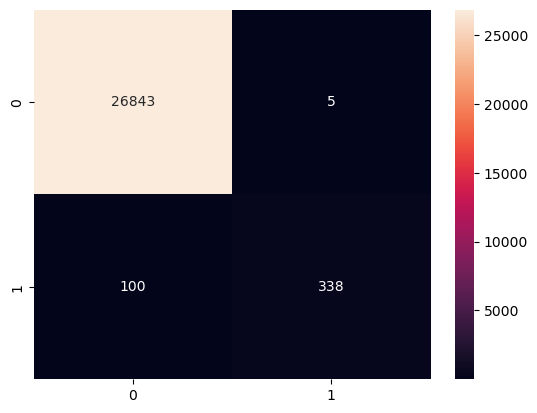

In [65]:
model_rf=RandomForestClassifier(n_estimators=50 , class_weight='balanced' , random_state=42)
search_space_rf = {'max_depth': np.geomspace(start=3, stop=50, num=10, dtype='int'),
'min_samples_leaf': np.geomspace(start=1, stop=500, num=10, dtype='int')}

model_rf_optimized_4=GridSearchCV(estimator=model_rf , param_grid=search_space_rf , cv=5 , scoring='f1' , n_jobs=-1)

model_rf_optimized_4.fit(features_train , target_train)

target_test_pred_optimized_rf=model_rf_optimized_4.predict(features_test)

print('gridsearch_results_RandomForestClassifier:')
print('rf_best_estimator_:',model_rf_optimized_4.best_estimator_)
print('rf_best_score_:',model_rf_optimized_4.best_score_)
print('\n')
print('F1_rf: ', f1_score(target_test, target_test_pred_optimized_rf))
print('Precision_rf: ', precision_score(target_test, target_test_pred_optimized_rf))
print('Recall_rf: ', recall_score(target_test, target_test_pred_optimized_rf))
confusion_matrix_rf_optimized= confusion_matrix(target_test, target_test_pred_optimized_rf)
sns.heatmap(confusion_matrix_rf_optimized, annot=True, fmt='d')